In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
import json
import os.path as path
import pickle

In [169]:
#load in the data by congressional session
def loader_data(year = 113):
    Respresentatives_ids = pd.read_csv(str(year)+"_SpeakerMap.txt", sep =  "|")
    Senator_meta = Respresentatives_ids[Respresentatives_ids["chamber"] == "S"]
    Senator_ids = list(set(Senator_meta["speakerid"]))
    Respresentatives_bygrams = pd.read_csv("byspeaker_2gram_"+str(year)+".txt", sep =  "|")
    partisan_bygrams = pd.read_csv("partisan_phrases_"+str(year)+".txt", sep =  "|")
    return Senator_ids, Respresentatives_bygrams,partisan_bygrams, Respresentatives_ids

#topic_lster this function reads in the topic phrases into a list
def topic_lster():
    topics_csv = pd.read_csv('topic_phrases.txt', sep =  "|")
    unique_topics = set(topics_csv.topic)

    len_lst = [] 
    topic_lst = []

    for count, top in enumerate(unique_topics):
        len_lst.append(len(topics_csv[topics_csv["topic"] == top]))
        topic_lst.append(top)
    topic_lst.sort()
    return topic_lst

#topic_bigram_dcter creates a dictionary key for each topic with values as dictionaries of the topic bigrams
def topic_bigram_dcter():
    topics_csv = pd.read_csv('topic_phrases.txt', sep =  "|")
    unique_topics = set(topics_csv.topic)
    topic_lst = []

    for count, top in enumerate(unique_topics):
        topic_lst.append(top)
    
    topic_lst.sort()
    topic_bigram_dct = {bigram_text: i for i,bigram_text in enumerate(topic_lst)}
    for topic in topic_lst:
        topic_bigram_lst = topics_csv[topics_csv["topic"] == topic].phrase.tolist() 
        topic_bigram_dct[topic] = {bigram_text: i for i,bigram_text in enumerate(topic_bigram_lst)}
    return topic_bigram_dct

#senator_vectoriser creates a dictionary for each senator with topics as keys and values as dictionary as frequency of topic bigrams
def senator_vectoriser(Senator_ids, Respresentatives_bygrams):
    senator2vocab = {new_list: {} for new_list in Senator_ids}
    topic_lst = topic_lster()
    for sen_index in senator2vocab:
        senator_bigram = Respresentatives_bygrams[Respresentatives_bygrams["speakerid"] == sen_index]["phrase"].tolist()
        senator_bigram_counts = Respresentatives_bygrams[Respresentatives_bygrams["speakerid"] == sen_index]["count"].tolist()
        senator2vocab[sen_index] = dict(zip(senator_bigram,senator_bigram_counts))

    senator2vector = {i: {} for i in Senator_ids}
    for senator in senator2vector:
        senator2vector[senator] = topic_bigram_dcter()

    for senator, vocab in senator2vocab.items():
        for topic in topic_lst:
            topic_bigram_dct = topic_bigram_dcter()
            senator_bigrams_topic = set(vocab.keys()).intersection(
                set(topic_bigram_dct[topic].keys()))

            temp = [0 for _ in range(len(topic_bigram_dct[topic]))]
            for b in senator_bigrams_topic:
                i = topic_bigram_dct[topic][b]
                temp[i] = vocab[b]
            senator2vector[senator][topic] = temp 
    return senator2vector

#normaliser function normalises each topic vector frequencies to 1
def normaliser(senator2vector):
    topic_lst = topic_lster()
    senator2vector_normalised = {i: {} for i in Senator_ids}

    for senator in senator2vector_normalised:
        senator2vector_normalised[senator] = topic_bigram_dcter()

    for senator in senator2vector:
        for topic in topic_lst:

            summed_bigram = sum(senator2vector[senator][topic])
            bigram_count_lst = []

            for ind, bigram_count in enumerate(senator2vector[senator][topic]):
                if summed_bigram > 0:
                    bigram_count_lst.append(bigram_count/summed_bigram)
                else:
                    bigram_count_lst.append(0)

            senator2vector_normalised[senator][topic] = bigram_count_lst    

    return senator2vector_normalised

#cluster creates senator clusters using hierachical AgglomerativeClustering with average linkage and cosine similarity 
def cluster(senator2vector_normalised_topic, distance = 0):
    X = np.array(senator2vector_normalised_topic) #sum_bigram_count #senator2vector
    clustering = AgglomerativeClustering(n_clusters = None, linkage = "average", distance_threshold = distance , affinity = "cosine").fit(X)
    return clustering

#party_vector creates a list senator clusters including metadata of state, party and name
def party_vector(Senator_ids, Respresentatives_ids, clustering):
    party_lst = []
    state_lst = []
    name_lst = []

    for sen in Senator_ids: 
        party_lst.append(Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].party.tolist()[0])
        if party_lst[len(party_lst)-1] == "I":
            party_lst[len(party_lst)-1] = "D"
        state_lst.append(Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].state.tolist()[0])
        lastname = Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].lastname.tolist()[0]
        firstname = Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].firstname.tolist()[0]
        name_lst.append(firstname+" "+lastname)
    
    party_vec = list(zip(list(clustering.labels_), party_lst, state_lst, name_lst))
    return party_vec

#puirty_calculator produces a score (purity) for each cluster, 
#this is the precentage of Democrats in each cluster transformed by a quadartic function (that penalises clusters of 50% from each party), 
#this purity score is weighted by number of elements of the cluster,
#then normalised dividing by (the number of elements in cluster/total number of senators)
def puirty_calculator(clustering, party_vec, length):
    cluster_dic = { i:[] for i in range(max(clustering.labels_+1))}
    
    for senator in party_vec:
        cluster_dic[senator[0]].append(senator[1])

    purity = []
    for i in cluster_dic:
        demo_score = (Counter(cluster_dic[i])['D']/len(cluster_dic[i]))
        score = ((4*(demo_score**2) - 4*demo_score +1) * len(cluster_dic[i]))*(len(cluster_dic[i])/len(Senator_ids))
        purity.append(score)
    return purity

#purity_finder then finds the purity score for each cluster distance, and returns the party vector for the optimal distance threshold
def purity_finder(senator2vector_normalised, Senator_ids, Respresentatives_ids):
    topic_aff_des = {}

    topic_lst = topic_lster()
    for topic in topic_lst:

        senator2vector_normalised_nonzero = []
        for senator in senator2vector_normalised:
            if sum(senator2vector_normalised[senator][topic]) > 0:
                senator2vector_normalised_nonzero.append(senator2vector_normalised[senator][topic])

        metric_dct = {}
        for distance in range(0,102,1):
            clustering = cluster(senator2vector_normalised_nonzero, distance/100)

            cluster_dic = {i:[] for i in range(max(clustering.labels_+1))}
            party_vec = party_vector(Senator_ids, Respresentatives_ids, clustering)
            party_vec.sort(key=lambda a:(a[0]))
            purity = puirty_calculator(clustering, party_vec, len(senator2vector_normalised_nonzero))
            metric_dct[distance/100] = sum(purity)

        party_aff_lst_R = []
        party_aff_lst_D = []
        for i in party_vec:
            if i[1] == "R":
                party_aff_lst_R.append(i[1])
            else:
                party_aff_lst_D.append(i[1])

        best_dist = list(metric_dct.keys())[list(metric_dct.values()).index(max(metric_dct.values()))]
        clustering = cluster(senator2vector_normalised_nonzero, best_dist)
        cluster_dic = {i:[] for i in range(max(clustering.labels_+1))}
        party_vec = party_vector(Senator_ids, Respresentatives_ids, clustering)
        party_vec.sort(key=lambda a:(a[0]))

        topic_aff_des[topic] = [round(max(metric_dct.values()),4), best_dist, len(party_aff_lst_R) + len(party_aff_lst_D), abs(len(party_aff_lst_R) - len(party_aff_lst_D)), len(list(np.unique(cluster(senator2vector_normalised_nonzero, best_dist).labels_))), party_vec]
    return topic_aff_des

In [11]:
#this function finds the optimal cluster for each congressional session based on purity score,
#returns a dictionay of sessions as keys and values the optimal score, distance threshold, number of senators, party vector
year_issues = {}
for i in range(97,115):
    if i < 100:
        year_issues["0"+str(i)] = []
    else:
        year_issues[str(i)] = []

for year in year_issues:
    print(year)
    Senator_ids, Respresentatives_bygrams,partisan_bygrams, Respresentatives_ids = loader_data(year)
    senator2vector = senator_vectoriser(Senator_ids, Respresentatives_bygrams)
    senator2vector_normalised = normaliser(senator2vector)
    year_issues[year] = purity_finder(senator2vector_normalised, Senator_ids, Respresentatives_ids)

#this function saves final output dictionary
# out_path = "year_issues_quad.pkl"
# with open(out_path, 'wb') as f_out:
#     pickle.dump(year_issues, f_out)

#this function reads in the saved output
issue_by_year = pd.read_pickle(r'year_issues_quad.pkl')

In [175]:
#this cell produce the necessary variables for plotting the topics by purity/democratic score across sessions
topic_dic = {}
name_topic_lst = []

for year in issue_by_year:
    topic_lst = []
    for i in issue_by_year[year]:
        name_topic_lst.append(i)
        inter_lst =[]
        inter_lst.append(i)
        inter_lst.extend(issue_by_year[year][i][0:5])
        topic_lst.append(inter_lst)
    topic_dic[year] = topic_lst

name_topic_lst = list(set(name_topic_lst))
name_topic_lst.sort(reverse = True)

issue_lst = []    
for year in issue_by_year:
    topic_dic[year].sort(key=lambda a:(a[0]), reverse = True)
    for issue in topic_dic[year][0:3]:
            issue_lst.append(issue[0])

#these commented lines counts the frequency of the three topics with the highest purity score 
# countFunc = Counter(issue_lst)
# print(countFunc)            
            
score_dict = {}
for year in topic_dic:
    score_lst = []
    for score in topic_dic[year]:
        score_lst.append(score[1])
    score_dict[year] = score_lst            
            
topic_dataframe = pd.DataFrame.from_dict(score_dict,orient='index', columns= name_topic_lst)

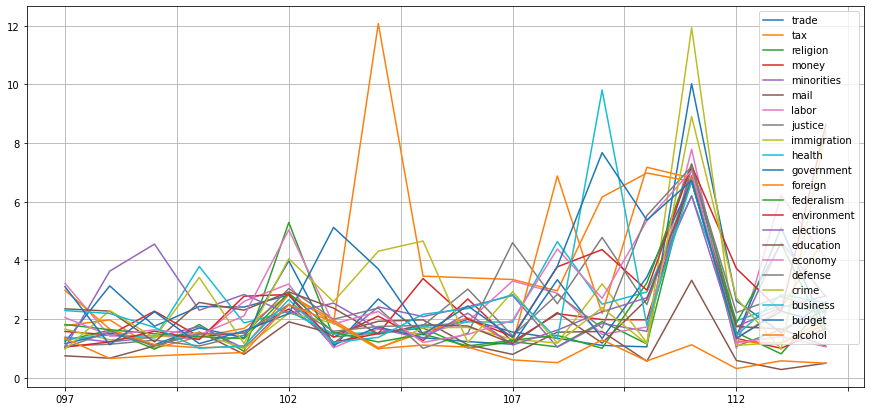

In [176]:
topic_dataframe.plot(figsize=(15,7))
plt.grid()
plt.show()

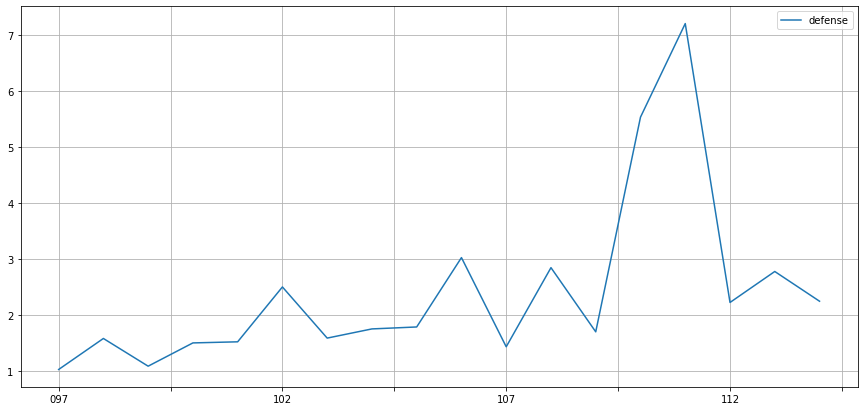

In [166]:
# f, axes = plt.figure(figsize = (15,9))
topic_dataframe[["defense"]].plot(figsize=(15,7))
plt.grid()
plt.show()

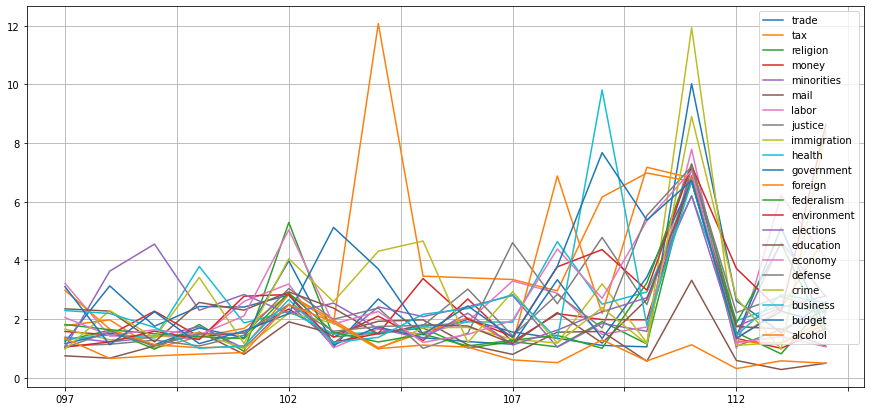

In [165]:
topic_dataframe.plot(figsize=(15,7))
plt.grid()
plt.show()